In [1]:
import sys
import os.path as path

kernel = str(get_ipython())

if 'google.colab' in kernel:    
    !rm -rf sample_data
    !wget https://raw.githubusercontent.com/fredzett/rmqa/master/utils.py -P local_modules -nc # Import own module
    !npx degit fredzett/rmqa/02_Datasets Datasets

    import sys
    sys.path.append('local_modules')
elif "ipykernel" in kernel:
    file_path =  os.path.abspath(path.join("utils.py" ,"../../.."))
    sys.path.append(file_path)  

In [4]:
import numpy as np
from utils import Datasets, plot_line

# Exercise 1

You are given the monthly index levels for the DAX 30 (stock index for the 30 largest companies in Germany, see [here](https://en.wikipedia.org/wiki/DAX)). 

- first entry: index level end of January 1990
- last entry: index level end of December 2019

**Please answer the following questions:**

1. What was the index level at March 1991?

2. What was the average index level in the first 12 month (i.e. in 1990)

3. What was the average index level in the year 2000

3. What was the maximum index level in the last 12 month (i.e. in 2019)

4. When was the maximum index level in 2019 reached (i.e. which month)

4. Calculate the monthly returns for the Dax. Monthly return ($r_i$) is defined as  $$r_i = \frac{P_i}{P_{i-1}} - 1$$

5. Calculate the monthly mean, median and standard deviation of returns (from February 1990 to December 2019)

6. What is the $95^{th}$ percentile of monthly returns? What does this?

7. Were there more months with positive or negative monthly returns?

8. How many month had a monthly return of below $-10\%$

7. Calculate a trimmed mean, median and standard deviation of returns where upper and lower $1%$ of returns are not included. What do you notice about the numbers?

8. Determine the months that were excluced for the trimmed return series (note: numpy indices are sufficient)

9. Write a function that calculates the trimmed mean where the user of this function can choose the lower and upper percentile

10. Make the above function more flexible and also enable calculation of other descriptive statistics (advanced!)

In [5]:
dax = Datasets.dax_monthly()
dax.shape

(360,)

## Solutions 1

In [6]:
# Index level in March 1991 
dax[14]

1515.319946

In [7]:
# Average index level in 1990
dax[:12].mean()

1688.9016621666667

In [8]:
# Average index level in year 2000
jan = (2000 - 1990)*12
dec = jan +12
dax[jan:dec].mean()

7049.201700833334

In [9]:
# Maximum index level in 2019
year = dax[-12:]
year.max()

13249.009766

In [10]:
# When was maximm index level in 2019 reached
year.argmax() # in December

11

In [11]:
# Calculalte return
ret = dax[1:] / dax[:-1] - 1
ret.shape

(359,)

In [12]:
# Calculate monthly standard deviation
mean = ret.mean()
median = np.median(ret)
std = ret.std(ddof=1) # DoF = 1 for sample standard deviation
mean, median, std

(0.007307348995584065, 0.01096234924927808, 0.05881664383998218)

In [13]:
# 95th percentile. 
np.percentile(ret,95)

0.0887152323318398

The $95^{th}$ percentile means that $95%$ of monthly returns are below this number. 

Let's see if we can check if the number seems valid. Our analysis implies that $5\%$ of our data has a higher return, i.e. ~18 data points (359*5%).

In [14]:
np.sum(ret > 0.0887)

18

We can also directly look a the data and check. 

In [15]:
np.sort(ret)[-18:]

array([0.08949041, 0.09063954, 0.09448739, 0.09503676, 0.09857672,
       0.09915045, 0.10082602, 0.10177645, 0.10886654, 0.11619729,
       0.11834363, 0.12257812, 0.12315165, 0.13861174, 0.16762066,
       0.16953777, 0.18013787, 0.21377792])

In [16]:
# Were there more months with positive or negative monthly returns?
np.sum(ret >0), np.sum(ret < 0) 

(210, 149)

In [133]:
# How many month had a below 10% return
np.sum(ret < -0.1)

13

In [120]:
# Trimmed mean excluding upper and lower 1%
lbound, ubound = np.quantile(ret,[.01,.99])
mask = (ret > lbound) & (ret < ubound)
ret_no_outlier = ret[mask]
ret_no_outlier.mean(), np.median(ret_no_outlier), ret_no_outlier.std(ddof=1)

(0.00768892099359191, 0.01096234924927808, 0.05169919274373985)

Mean and standard deviation change given their sensitivity to outliers. Median does not change as it is not sensitive to outliers.

In [121]:
# Determine the months that were excluded
excluded = (ret < lbound) | (ret > ubound)
np.argwhere(excluded)

array([[  7],
       [ 89],
       [102],
       [118],
       [151],
       [158],
       [230],
       [258]])

Alternatively we can also use the negation of what we have previously calculated

In [122]:
np.argwhere(~mask)

array([[  7],
       [ 89],
       [102],
       [118],
       [151],
       [158],
       [230],
       [258]])

In [136]:
# Function "trimmed mean"
def trimmed_mean(data,lbound,ubound):
    low,up = np.quantile(data,[lbound,ubound])
    mask = (data > low) & (data < up)
    mean = np.mean(data[mask])
    return mean

In [137]:
trimmed_mean(ret,0.01,0.99)

0.00768892099359191

In [151]:
# More flexible function 
def trimmed(data,lbound, ubound,f):
    low,up = np.quantile(data,[lbound,ubound])
    mask = (data > low) & (data < up)
    stat = f(data[mask])
    return stat

In [150]:
trimmed(ret, 0.01,0.99, np.median)

0.01096234924927808

# Exercise 2

You are given the below **project cash flows** for the coming years $1, \ldots, 10$:

|    1   |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  |  10 |
|:------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| -1.000 | 200 | 210 | 221 | 232 | 243 | 255 | 268 | 281 | 295 |

The cost of capital ($r$) is  $5\%$.

Please answer the **folowing questions**:

1. The net present value of the project

2. The payback period of the project (how long (here: years) does it take until the money is earned back)

    1. for nominal cash flows
    
    2. for discounted cash flows


3. Function to calculate the npv (NOTE: assume that initial year is always Year 1)

4. Calculate the internal rate of return, i.e. calcualte $r$ for with the Net Present Value is $0$ 



----

**Note**: the net present value (npv) is defined as: 

$$\text{NPV} = \sum_t^T CF_t \cdot \frac{1}{(1+r)^t}$$


## Solution 2

In [49]:
# Assumptions from exercise
cfs = np.array((-1000,200,210,221,232,243,255,268,281,295))
r = 0.05
t = np.arange(1,11)

**What is the net present value?**

In [18]:
npv = np.sum(cfs * 1/(1+r)**t)
print("The project NPV is:", npv)

The project NPV is: 680.2127013932504


**What is the payback period**

(1) Nominal

In [25]:
# What is the Payback period
pb_nominal = np.cumsum(cfs)
pb_nominal

array([-1000,  -800,  -590,  -369,  -137,   106,   361,   629,   910,
        1205])

In [26]:
idx = min(np.argwhere(pb_nominal > 0))
t[idx] # Year 6

array([6])

(2) Discounted

In [27]:

pb_discounted = np.cumsum(cfs * 1/(1+r)**t)
pb_discounted

array([-952.38095238, -770.97505669, -589.569161  , -407.75191407,
       -225.97384345,  -44.64350207,  136.58023712,  317.97318614,
        499.1082916 ,  680.21270139])

In [29]:
idx = min(np.argwhere(pb_discounted > 0))
t[idx] # Year 7

array([7])

**Function to calculate NPV**

In [30]:
def npv(cfs, r=0.05):
    t = np.arange(1,len(cfs)+1) # t depend on length of cfs
    df = 1 / (1 + r) ** t
    return np.sum(cfs * df)

In [43]:
cashflows = np.array((200,300,100,400))
npv(cashflows) # NPV for r = 5%

878.0497837835057

In [44]:
npv(cfs,r=0.1) # NPV for r = 10%

778.0889283518884

**Internal rate of return**

In [51]:
# Calculate NPVs for different r
rs = np.linspace(0.001,0.3,1000)
npvs = np.empty(len(rs))
for i, r in enumerate(rs):
    npvs[i] = npv(cfs,r)

In [52]:
# Find NPV lowest to zero
idx = (np.abs(npvs)).argmin()
irr = rs[idx]
irr # when r ~18% the NPV is zero 

0.18028028028028026

In [53]:
npv(cfs,irr) # Check

-0.3804790592929237

Visual inspection

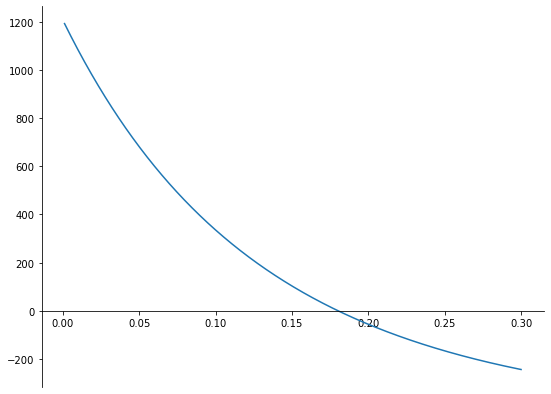

In [63]:
plot_line(rs,npvs);